## Libraries

In [79]:
import numpy as np
import pandas as pd
import yfinance as yf

import pickle
import random

import matplotlib.pyplot as plt
import seaborn as sns

## Getting Data

In [2]:
# DO NOT RUN
# INFO CONTAINED IN LIST IN nasdaq_tickers.txt
# USE PICKLE

# nasdaq_tickers = []
# for character in [chr(i) for i in np.arange(26)+ord('A')]:
#     nasdaq_tickers.append(
#         pd.read_html(
#             'https://eoddata.com/stocklist/NASDAQ/' + character + '.htm'
#         )[4]['Code'].tolist()
#     )
# nasdaq_tickers = list(np.concatenate(nasdaq_tickers).flat)

In [3]:
def write_list_to_text_file(a_list, list_file):
    with open(list_file, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into binary file')

def read_list(list_file):
    with open(list_file, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [4]:
# DO NOT RUN
# FILE ALREADY POPULATED

# write_list_to_text_file(nasdaq_tickers, 'nasdaq_tickers.txt')

In [5]:
# get all nasdaq tickers
nasdaq_tickers_full = read_list('nasdaq_tickers.txt')

In [6]:
# get tickers in nasdaq 100
nasdaq_100_tickers = pd.read_html(
        'https://en.wikipedia.org/wiki/Nasdaq-100'
    )[4].Ticker.to_list()

In [7]:
nasdaq_100_start_2010_close = yf.download(
    nasdaq_100_tickers, start='2010-01-01'
)['Close']

nasdaq_100_start_2010_adjclose = yf.download(
    nasdaq_100_tickers, start='2010-01-01'
)['Adj Close']

[*********************100%***********************]  101 of 101 completed
[*********************100%***********************]  101 of 101 completed


In [8]:
nasdaq_100_start_2010_adjclose

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,...,TSLA,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.515212,NaN,37.090000,23.067621,27.491203,25.670000,21.142141,18.500000,11.328526,9.700000,...,NaN,18.767336,29.074842,44.240002,26.326168,15.840572,NaN,13.504498,NaN,NaN
2010-01-05,6.526475,NaN,37.700001,23.031204,27.343586,25.280001,20.900103,18.010000,11.241390,9.710000,...,NaN,18.659101,29.269650,42.779999,26.114426,16.463976,NaN,13.344336,NaN,NaN
2010-01-06,6.422663,NaN,37.619999,22.987495,27.279394,25.340000,21.111881,17.480000,11.217622,9.570000,...,NaN,18.522017,29.649521,42.029999,25.916803,16.709249,NaN,13.369963,NaN,NaN
2010-01-07,6.410792,NaN,36.889999,22.805408,27.266565,25.480000,21.293409,17.430000,11.098794,9.470000,...,NaN,18.579733,29.600817,41.500000,26.072083,16.699030,NaN,13.312306,NaN,NaN
2010-01-08,6.453413,NaN,36.689999,22.936514,27.228043,26.260000,21.547552,17.660000,11.526579,9.430000,...,NaN,19.005444,29.220947,40.669998,26.107367,16.750128,NaN,13.318717,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,125.070000,84.900002,336.920013,162.449997,237.660004,185.149994,94.870003,212.279999,96.730003,64.019997,...,108.099998,163.210007,177.339996,286.019989,37.189999,9.540000,169.350006,70.070000,66.660004,110.190002
2023-01-04,126.360001,88.720001,341.410004,165.910004,238.779999,187.960007,95.519997,224.630005,99.309998,64.660004,...,113.639999,169.169998,180.250000,286.829987,37.490002,10.380000,171.220001,70.669998,67.650002,111.589996
2023-01-05,125.019997,87.709999,328.440002,159.690002,233.630005,182.070007,93.779999,219.820007,97.919998,62.330002,...,110.339996,166.929993,177.639999,287.890015,35.189999,10.860000,160.190002,69.239998,65.620003,104.389999


The video I'm watching to get into this is dropping all columns with NaN values to "reduce survivorship bias". But that's still valuable data, and I don't want to get rid of it. I'll have to come back to this, as I want to include these companies in month-over-month analysis.

In [9]:
nasdaq_100_start_2010_adjclose_nadrop = nasdaq_100_start_2010_adjclose.dropna(axis=1)

In [10]:
nasdaq_100_start_2010_adjclose_nadrop.shape

(3277, 78)

In [11]:
# daily percent change
nasdaq_100_start_2010_adjclose_nadrop.pct_change()[:10]

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SGEN,SIRI,SNPS,TMUS,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.016446,-0.001579,-0.005370,-0.015193,-0.011448,-0.026486,-0.007692,0.001031,-0.008663,...,-0.000949,0.061539,-0.008467,0.002509,-0.005767,0.006700,-0.033002,-0.008043,0.039355,-0.011860
2010-01-06,-0.015906,-0.002122,-0.001898,-0.002348,0.002373,0.010133,-0.029428,-0.002114,-0.014418,-0.007515,...,0.027540,0.000000,-0.001798,-0.067585,-0.007347,0.012978,-0.017532,-0.007568,0.014898,0.001920
2010-01-07,-0.001848,-0.019405,-0.007921,-0.000470,0.005525,0.008598,-0.002860,-0.010593,-0.010449,-0.009156,...,-0.005545,-0.028985,-0.002701,0.009396,0.003116,-0.001643,-0.012610,0.005991,-0.000612,-0.004312
2010-01-08,0.006648,-0.005422,0.005749,-0.001413,0.030612,0.011935,0.013196,0.038543,-0.004224,0.008885,...,0.005576,0.000000,0.007223,-0.055851,0.022913,-0.012833,-0.020000,0.001353,0.003060,0.000482
2010-01-11,-0.008822,-0.013083,-0.005716,0.004479,-0.000381,0.010390,-0.006795,0.021993,-0.030753,0.004404,...,-0.020333,0.029851,-0.008516,0.012676,-0.012908,-0.002333,0.028522,0.001622,-0.003356,0.009619
2010-01-12,-0.011375,-0.015189,-0.041520,-0.007041,-0.013714,-0.010005,-0.017674,-0.045057,-0.053611,-0.017362,...,-0.026415,-0.014493,-0.014467,-0.116829,-0.041923,0.007685,-0.000956,-0.008368,-0.026630,0.011910
2010-01-13,0.014106,0.017386,-0.000334,0.007327,0.013905,0.012352,0.020313,0.004930,0.057803,0.008924,...,0.032946,-0.014706,0.009633,-0.003150,0.004416,-0.000332,0.022254,0.009255,0.005975,0.015537
2010-01-14,-0.005792,-0.010474,-0.001000,-0.002816,0.013333,0.003883,-0.025597,0.005606,-0.016393,-0.006545,...,0.000938,0.014925,0.008178,-0.015798,-0.012390,-0.007960,-0.033240,0.000809,-0.008128,0.001854


In [12]:
# calculate monthly returns
nd100st2010adjclnadrp_monthly_returns = (
    nasdaq_100_start_2010_adjclose_nadrop.pct_change()+1
)[1:].resample('M').prod()

In [13]:
# view monthly returns
nd100st2010adjclnadrp_monthly_returns

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SGEN,SIRI,SNPS,TMUS,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-31,0.897435,0.870855,0.851279,0.952370,0.926763,0.991700,1.013514,0.851749,0.769072,1.013167,...,0.979127,1.292308,0.947861,0.706399,0.869486,0.942044,0.867993,0.966488,0.956774,0.985768
2010-02-28,1.065396,1.072755,1.084570,1.020103,1.171921,0.982246,0.965333,1.009773,1.060322,0.968023,...,0.988372,1.214286,1.029619,1.095915,1.083556,1.006401,1.055729,0.981576,1.050236,1.001444
2010-03-31,1.148470,1.020779,0.992336,1.077120,1.053802,1.016657,1.068508,1.100490,1.171934,1.057057,...,1.170588,0.852941,1.021461,1.147488,1.003692,0.996467,1.008140,1.052497,1.084751,1.030483
2010-04-30,1.111022,0.949958,1.038515,0.975264,1.156910,1.003510,0.879007,1.023014,0.978425,0.957721,...,1.055276,1.356322,1.012964,1.077684,1.067762,0.993617,0.948618,0.947695,1.146197,1.025944
2010-05-31,0.983875,0.954762,0.982143,0.942587,0.860841,0.943656,0.877647,0.942779,0.944873,0.903507,...,1.050000,0.872881,0.945278,1.178244,0.938870,1.079586,0.892185,0.915058,0.972373,0.942069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,0.879023,0.736932,0.919554,0.929452,0.925944,0.862774,0.849856,0.870947,0.746554,0.937994,...,0.886837,0.937603,0.882926,0.931995,0.936868,0.912665,1.027612,0.895608,0.868580,0.867592
2022-10-31,1.109551,1.157340,1.023540,1.068571,1.147216,1.017004,0.938149,1.077627,0.947917,1.199423,...,0.929328,1.057793,0.957579,1.129612,1.046070,1.072128,1.077571,1.162420,1.130435,1.017344
2022-11-30,0.966973,1.082983,1.205371,1.092842,0.942370,1.111336,1.012146,1.244386,1.292541,1.066664,...,0.954624,1.078573,1.160622,0.999340,1.123451,1.004813,1.014103,1.150369,0.876923,1.078483


## Random Strategy Bot

In [14]:
# random number of stocks to buy
n_stock_purchases = np.random.randint(1, 79)

# CONSTANT
n_stock_purchases = 10
print(n_stock_purchases)

10


In [15]:
# random tickers to purchase
random_tickers = random.sample(
    list(nasdaq_100_start_2010_adjclose_nadrop.columns),
    n_stock_purchases
)

print(random_tickers[:10])

['MCHP', 'AVGO', 'FAST', 'HON', 'CSGP', 'ANSS', 'QCOM', 'XEL', 'CTSH', 'ORLY']


In [16]:
# random percent of portfolio to invest in each ticker
random_percent_portfolio_invested = np.random.random(n_stock_purchases)
random_percent_portfolio_invested /= random_percent_portfolio_invested.sum()
print(random_percent_portfolio_invested)

[0.08262647 0.06696749 0.12862638 0.09134127 0.12063426 0.04123673
 0.15650768 0.13969619 0.12912819 0.04323534]


In [17]:
# total portfolio value
porfolio_total_dollars = 1000000.0

In [18]:
# total amount invested in each stock
portfolio_invest_totals = (
    porfolio_total_dollars * random_percent_portfolio_invested
)
print(portfolio_invest_totals)

[ 82626.47075012  66967.49467235 128626.37620049  91341.26751235
 120634.25848411  41236.72895633 156507.68375102 139696.1890628
 129128.18628609  43235.34432433]


In [19]:
nasdaq_100_start_2010_adjclose_nadrop[random_tickers]

,MCHP,AVGO,FAST,HON,CSGP,ANSS,QCOM,XEL,CTSH,ORLY
Date,,,,,,,,,,
2010-01-04,10.315319,13.895465,7.551793,28.948040,4.225000,44.639999,33.575775,13.504498,21.795559,38.500000
2010-01-05,10.152700,13.998611,7.708112,29.005449,4.245000,43.639999,34.384060,13.344336,22.042395,38.560001
2010-01-06,10.067863,14.109128,8.216594,29.005449,4.250000,43.349998,34.047867,13.369963,22.042395,38.389999
2010-01-07,10.014837,14.020715,8.356742,29.565037,4.242000,43.459999,35.034973,13.312306,21.208759,38.270000
2010-01-08,10.074937,14.123864,8.441190,30.217903,4.234000,43.759998,35.385468,13.318717,21.823507,37.930000
...,...,...,...,...,...,...,...,...,...,...
2023-01-03,69.099998,553.479980,47.400002,214.300003,77.650002,238.639999,107.199997,70.070000,57.590000,840.719971
2023-01-04,70.790001,560.239990,47.970001,210.039993,78.000000,242.940002,111.529999,70.669998,58.060001,826.739990
2023-01-05,69.099998,555.020020,46.299999,204.470001,74.900002,231.649994,109.400002,69.239998,57.570000,834.289978


In [20]:
# shares purchased, total dollar per ticker, total investment, uninvested amount
def purchase_data(purchase_date):
    random_tickers_df = nasdaq_100_start_2010_adjclose_nadrop[random_tickers]
    ticker_prices = random_tickers_df.loc[purchase_date].values

    shares_purchased = portfolio_invest_totals // ticker_prices
    funds_per_ticker = shares_purchased * ticker_prices
    total_investment = sum(shares_purchased * ticker_prices)
    portfolio_remainder = porfolio_total_dollars - total_investment
    return shares_purchased, funds_per_ticker, total_investment, portfolio_remainder

In [21]:
sp, fpt, ti, pr = purchase_data('2010-01-05')
print(sp)
print(fpt)
print(ti)
print(pr)

[ 8138.  4783. 16687.  3149. 28417.   944.  4551. 10468.  5858.  1121.]
[ 82622.67605209  66955.35856628 128625.26894617  91338.15983009
 120630.16174793  41196.15942383 156481.85663223 139688.50460052
 129124.34778976  43225.76153946]
999888.2551283836
111.74487161636353


In [22]:
# January 2010 percent change in random choice tickers
random_tickers_change = nd100st2010adjclnadrp_monthly_returns[random_tickers]
random_ticker_change_2010m1 = random_tickers_change.loc['2010-01-31'].values
print(random_ticker_change_2010m1)

[0.88450968 0.92152721 0.98691383 0.95762125 0.95573969 0.93772404
 0.83489599 0.98576836 0.93290602 0.98181816]


In [23]:
# new portfolio value
funds_change = fpt * random_ticker_change_2010m1
new_portfolio_value = sum(funds_change) + pr
print(new_portfolio_value)

934471.8701805602


In [24]:
def random_strategy_monthly(portfolio_value, df, month_begin, month_end, verbose=False):
    # random number of tickers
    n_stock_purchases = np.random.randint(1, df.shape[1])
    # random ticker names to purchase
    random_tickers = random.sample(list(df.columns), n_stock_purchases)
    # random percent of portfolio to invest in each ticker
    random_percent_portfolio_invested = np.random.random(n_stock_purchases)
    random_percent_portfolio_invested /= random_percent_portfolio_invested.sum()
    # total amount invested in each ticker
    portfolio_invest_totals = porfolio_total_dollars * random_percent_portfolio_invested
    # dataframe of tickers
    random_df = df[random_tickers]
    # ticker prices
    ticker_prices = random_df.loc[month_begin].values
    # shares purchased per ticker
    shares_purchased = portfolio_invest_totals // ticker_prices
    # total dollars invested in each ticker
    dollars_per_ticker = shares_purchased * ticker_prices
    # total amount invested
    total_investment = sum(shares_purchased * ticker_prices)
    # uninvested portfolio amount
    portfolio_remainder = porfolio_total_dollars - total_investment

    # ticker percent change by month
    random_df_pct_change = (random_df.pct_change()+1)[1:].resample('M').prod()
    month_end_change = random_df_pct_change.loc[month_end].values
    
    # total dollar change by ticker
    total_dollar_change = dollars_per_ticker * month_end_change
    # portfolio total dollar amount after investment
    new_portfolio_value = sum(total_dollar_change) + portfolio_remainder

    # expanded info for viewing choices
    if verbose:
        n_verbose = 5
        print('Stocks:', n_stock_purchases)
        print('Tickers:', random_tickers[:n_verbose])
        print('Percent Portfolio Invested:', random_percent_portfolio_invested[:n_verbose])
        print('Total Invested Per Ticker:', portfolio_invest_totals[:n_verbose])
        print('Ticker Prices', ticker_prices[:n_verbose])
        print('Shares Purchased:', shares_purchased[:n_verbose])
        print('Dollars Per Ticker:', dollars_per_ticker[:n_verbose])
        print('Total Investment:', total_investment)
        print('Portfolio Remainder:', portfolio_remainder)
        print('Month End Change:', month_end_change[:n_verbose])
        print('Total Dollar Change:', total_dollar_change[:n_verbose])

    return new_portfolio_value

In [25]:
portfolio_total_dollars = 1000000.0

In [26]:
# test random strategy against January 2010
random_strategy_monthly(
    portfolio_total_dollars,
    nasdaq_100_start_2010_adjclose_nadrop,
    '2010-01-04',
    '2010-01-31',
    verbose=True
)

Stocks: 5
Tickers: ['CSX', 'AMGN', 'CPRT', 'AMD', 'ADBE']
Percent Portfolio Invested: [0.0057436  0.02364128 0.28202227 0.34435094 0.34424191]
Total Invested Per Ticker: [  5743.59634858  23641.28236055 282022.27102453 344350.94050343
 344241.90976291]
Ticker Prices [ 4.28582716 43.26717758  4.55124998  9.69999981 37.09000015]
Shares Purchased: [ 1340.   546. 61965. 35500.  9281.]
Dollars Per Ticker: [  5743.00839424  23623.87895966 282018.20506811 344349.99322891
 344232.29141617]
Total Investment: 999967.3770670891
Portfolio Remainder: 32.62293291091919
Month End Change: [0.87720047 1.01316707 0.92721776 0.76907218 0.87085465]
Total Dollar Change: [  5037.76965141  23934.9363327  261492.28699923 264830.00135422
 299776.29291916]


855103.9101896286

In [27]:
# for finding purchase dates
        # finds next available market open date after 1st of month
def find_next_date(date):
    date = pd.to_datetime(date)
    while date not in nasdaq_100_start_2010_adjclose_nadrop.index:
            date += pd.offsets.Day(1)
    return date

In [28]:
find_next_date('2010-01-01')

Timestamp('2010-01-04 00:00:00')

In [29]:
# get purchase and sell dates
sell_dates = pd.date_range('2010-01-01', '2023-01-01', freq='1M')
dates = sell_dates-pd.offsets.MonthBegin(1)
purchase_dates = pd.DatetimeIndex([find_next_date(date) for date in dates])


In [30]:
print(sell_dates[-5:])
print(purchase_dates[-5:])

DatetimeIndex(['2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30',
               '2022-12-31'],
              dtype='datetime64[ns]', freq='M')
DatetimeIndex(['2022-08-01', '2022-09-01', '2022-10-03', '2022-11-01',
               '2022-12-01'],
              dtype='datetime64[ns]', freq=None)


In [31]:
# test random strategy against period January 2010 to current
df = nasdaq_100_start_2010_adjclose_nadrop
portfolio_history = [1000000.0]
updated_portfolio_amount = 0.0
for i in range(len(purchase_dates)):
    portfolio_return = random_strategy_monthly(
        updated_portfolio_amount,
        df,
        purchase_dates[i],
        sell_dates[i]
    )

    portfolio_history.append(portfolio_return)
    updated_portfolio_amount = portfolio_return

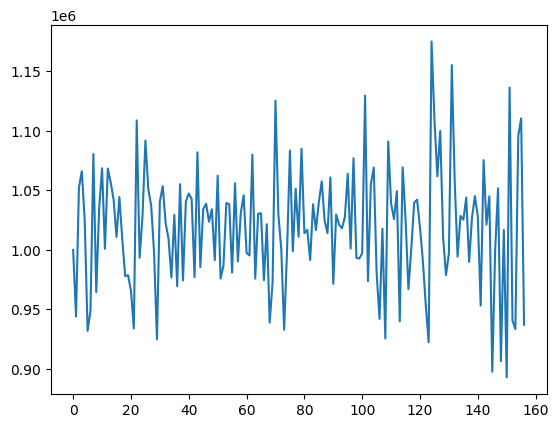

In [32]:
# plot strategy returns
plt.plot(portfolio_history)

In [33]:
# test random strategy against period January 2010 to current
df = nasdaq_100_start_2010_adjclose_nadrop
tested_portfolios = []
for j in range(100):
    portfolio_history = [1000000.0]
    updated_portfolio_amount = 0.0
    for i in range(len(purchase_dates)):
        portfolio_return = random_strategy_monthly(
            updated_portfolio_amount,
            df,
            purchase_dates[i],
            sell_dates[i]
        )

        portfolio_history.append(portfolio_return)
        updated_portfolio_amount = portfolio_return

    tested_portfolios.append(portfolio_history)
    

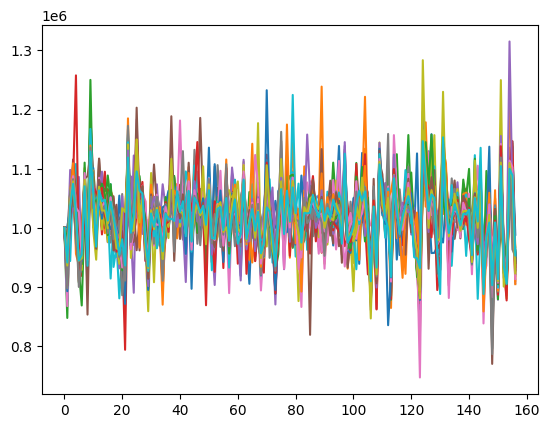

In [34]:
# plot returns of 100 tested portfolios
for i in range(len(tested_portfolios)):
    plt.plot(tested_portfolios[i])

In [35]:
# transpose for analysis
tested_portfolios_T = np.array(tested_portfolios).T

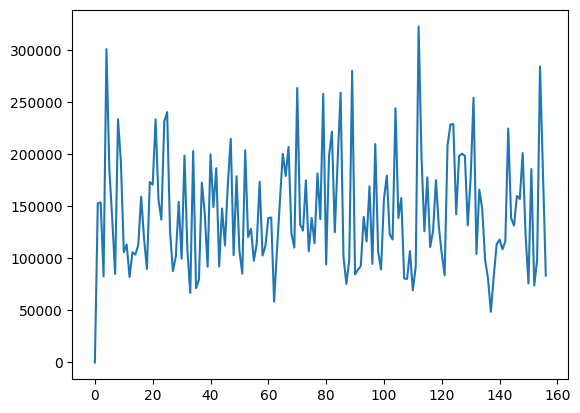

In [36]:
# high - low spread of returns
return_spread = [max(month_returns)-min(month_returns) for month_returns in tested_portfolios_T]
plt.plot(return_spread)

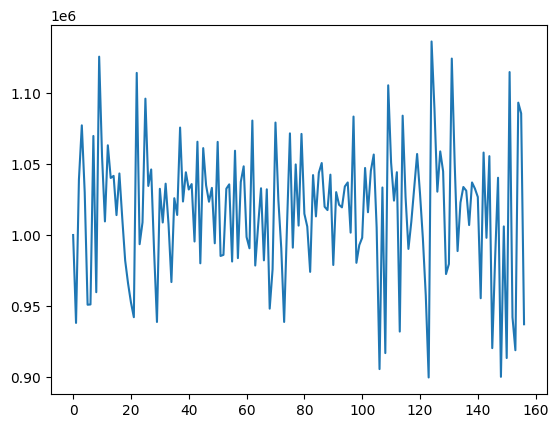

In [37]:
# mean of returns
return_average = [month_returns.mean() for month_returns in tested_portfolios_T]
plt.plot(return_average)

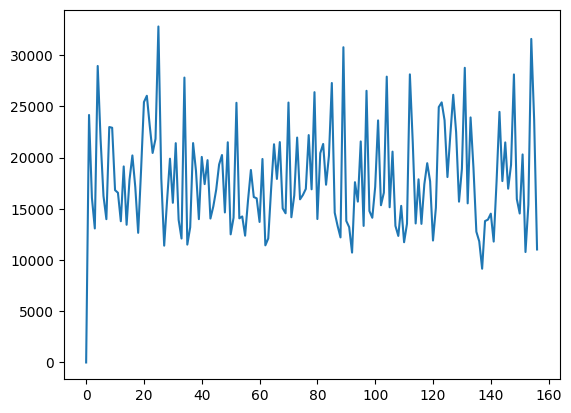

In [38]:
# standard deviation of returns
return_std = [np.std(month_returns) for month_returns in tested_portfolios_T]
plt.plot(return_std)

## Cascading Momentum Strategy

In [39]:
# get rolling returns
    # accumulate percent returns of n months
def get_rolling_ret(df, n):
    return df.rolling(n).apply(np.prod)

In [40]:
# shorter dataframe names for easier use
nd78 = nasdaq_100_start_2010_adjclose_nadrop.copy()
nd78_month_pct = nd100st2010adjclnadrp_monthly_returns.copy()

In [41]:
# original nasdaq price dataframe (78 companies)
nd78.head()

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SGEN,SIRI,SNPS,TMUS,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.515212,37.090000,23.067621,27.491203,25.670000,21.142141,18.50,11.328526,9.70,43.267178,...,10.54,0.579823,22.440001,13.207044,18.767336,29.074842,44.240002,26.326168,15.840572,13.504498
2010-01-05,6.526475,37.700001,23.031204,27.343586,25.280001,20.900103,18.01,11.241390,9.71,42.892368,...,10.53,0.615505,22.250000,13.240186,18.659101,29.269650,42.779999,26.114426,16.463976,13.344336
2010-01-06,6.422663,37.619999,22.987495,27.279394,25.340000,21.111881,17.48,11.217622,9.57,42.570049,...,10.82,0.615505,22.209999,12.345354,18.522017,29.649521,42.029999,25.916803,16.709249,13.369963
2010-01-07,6.410792,36.889999,22.805408,27.266565,25.480000,21.293409,17.43,11.098794,9.47,42.180260,...,10.76,0.597664,22.150000,12.461351,18.579733,29.600817,41.500000,26.072083,16.699030,13.312306
2010-01-08,6.453413,36.689999,22.936514,27.228043,26.260000,21.547552,17.66,11.526579,9.43,42.555046,...,10.82,0.597664,22.309999,11.765371,19.005444,29.220947,40.669998,26.107367,16.750128,13.318717


In [42]:
# monthly percent change for each stock
nd78_month_pct.head()

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SGEN,SIRI,SNPS,TMUS,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-31,0.897435,0.870855,0.851279,0.952370,0.926763,0.991700,1.013514,0.851749,0.769072,1.013167,...,0.979127,1.292308,0.947861,0.706399,0.869486,0.942044,0.867993,0.966488,0.956774,0.985768
2010-02-28,1.065396,1.072755,1.084570,1.020103,1.171921,0.982246,0.965333,1.009773,1.060322,0.968023,...,0.988372,1.214286,1.029619,1.095915,1.083556,1.006401,1.055729,0.981576,1.050236,1.001444
2010-03-31,1.148470,1.020779,0.992336,1.077120,1.053802,1.016657,1.068508,1.100490,1.171934,1.057057,...,1.170588,0.852941,1.021461,1.147488,1.003692,0.996467,1.008140,1.052497,1.084751,1.030483
2010-04-30,1.111022,0.949958,1.038515,0.975264,1.156910,1.003510,0.879007,1.023014,0.978425,0.957721,...,1.055276,1.356322,1.012964,1.077684,1.067762,0.993617,0.948618,0.947695,1.146197,1.025944
2010-05-31,0.983875,0.954762,0.982143,0.942587,0.860841,0.943656,0.877647,0.942779,0.944873,0.903507,...,1.050000,0.872881,0.945278,1.178244,0.938870,1.079586,0.892185,0.915058,0.972373,0.942069


In [43]:
# 12 month return for each stock
nd78_12m = get_rolling_ret(nd78_month_pct, 12)[11:]
nd78_12m.head()

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SGEN,SIRI,SNPS,TMUS,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,1.507220,0.829873,1.223493,1.116250,1.488118,1.081272,1.056216,1.004638,0.843299,0.951144,...,1.418406,2.507693,1.199198,1.584693,1.273198,1.141709,0.791817,1.064760,1.345161,1.168596
2011-01-31,1.766740,1.023220,1.481500,1.213104,1.709962,1.081232,1.110933,1.317179,1.049598,0.941860,...,1.588178,1.928571,1.275505,2.296625,1.533648,1.203058,1.012760,1.143529,1.314902,1.186474
2011-02-28,1.726176,0.995671,1.402916,1.241333,1.508250,1.118131,1.151934,1.371910,1.164349,0.906730,...,1.455882,1.774510,1.265753,2.333874,1.486342,1.143109,1.151209,1.253718,1.383949,1.203362
2011-03-31,1.483021,0.937518,1.403911,1.191077,1.501362,1.080139,1.058945,1.185176,0.927724,0.893215,...,1.304020,1.896552,1.236030,2.293785,1.437210,1.161702,1.172743,1.103233,1.180823,1.177905
2011-04-30,1.341032,0.998512,1.383770,1.293884,1.323330,1.117406,1.420000,1.163705,1.003308,0.991973,...,1.318254,1.686441,1.208738,2.205767,1.388809,1.174161,1.419912,1.238947,1.142783,1.169265


In [44]:
# 6 month return for each stock
nd78_6m = get_rolling_ret(nd78_month_pct, 6)[5:]
nd78_6m.head()

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SGEN,SIRI,SNPS,TMUS,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-30,1.175318,0.712591,0.892526,0.955278,0.948968,0.947777,0.803784,0.849287,0.754639,0.911296,...,1.137571,1.461539,0.930036,1.027603,0.903715,1.001675,0.743671,0.721568,1.151935,1.000755
2010-07-31,1.339425,0.889164,1.118074,1.028218,1.241698,1.064595,0.925333,0.978861,1.004021,0.932456,...,1.180233,1.226190,1.026798,1.589698,1.107513,1.055832,0.876562,0.798317,1.301753,1.083179
2010-08-31,1.188056,0.799423,0.974707,0.942988,0.994620,1.079115,0.883425,0.857322,0.709229,0.901607,...,1.122549,0.941176,1.043836,1.448946,0.952976,0.983039,0.821658,0.770512,1.211878,1.097357
2010-09-30,1.207447,0.739327,1.105542,0.961256,1.088155,1.086015,1.012410,0.877449,0.766990,0.920956,...,1.300670,1.379310,1.107287,1.477401,1.119402,0.993262,0.845853,0.912376,1.288843,1.108518
2010-10-31,1.152782,0.837798,1.142228,1.043326,1.065019,1.118360,1.001176,0.906910,0.809261,0.997906,...,1.302381,1.271187,1.128861,1.363041,1.147295,1.063883,0.987877,0.973653,1.153369,1.122351


In [45]:
# 3 month return for each stock
nd78_3m = get_rolling_ret(nd78_month_pct, 3)[2:]
nd78_3m.head()

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SGEN,SIRI,SNPS,TMUS,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-31,1.098080,0.953626,0.916196,1.046439,1.144527,0.990318,1.045405,0.946502,0.955670,1.036729,...,1.132827,1.338462,0.996881,0.888331,0.945615,0.944724,0.923825,0.998484,1.090000,1.017285
2010-04-30,1.359419,1.040248,1.117711,1.071594,1.428752,1.002113,0.906667,1.136820,1.215818,0.979994,...,1.220930,1.404762,1.065350,1.355240,1.161251,0.996444,1.009635,0.979069,1.305799,1.058744
2010-05-31,1.255401,0.925830,1.012154,0.990165,1.049498,0.962742,0.824309,1.061397,1.083439,0.914679,...,1.297059,1.009804,0.978082,1.457050,1.006190,1.068905,0.853231,0.912721,1.208989,0.995972
2010-06-30,1.070340,0.747243,0.974165,0.912885,0.829136,0.957042,0.768873,0.897291,0.789644,0.879011,...,1.004188,1.091954,0.932946,1.156780,0.955690,1.060283,0.804991,0.722663,1.056821,0.983751
2010-07-31,0.985292,0.854762,1.000325,0.959522,0.869079,1.062351,1.020588,0.861052,0.825799,0.951492,...,0.966667,0.872881,0.963813,1.173001,0.953725,1.059600,0.868197,0.815384,0.996902,1.023079


In [46]:
# get top 10 tickers by cascading momentum strategy
    # top 50 performers over 12 months
    # of those, top 30 performers over 6 months
    # of those, top 10 performers over 3 months
def get_top10_momentum_stocks(previous_month_end):
    top_50 = nd78_12m.loc[previous_month_end].nlargest(50).index
    top_30 = nd78_6m.loc[previous_month_end, top_50].nlargest(30).index
    return nd78_3m.loc[previous_month_end, top_30].nlargest(10).index

In [47]:
# constant previous month end for testing
previous_month_end = pd.to_datetime('2010-12-31')

In [48]:
chosen_stocks = get_top10_momentum_stocks('2010-12-31')
chosen_stocks

Index(['LULU', 'SIRI', 'BKR', 'FTNT', 'ILMN', 'AVGO', 'SBUX', 'ODFL', 'LRCX',
       'HON'],
      dtype='object')

In [49]:
# returns of month after previous month end
cascading_strategy_month_pct_ret = nd78_month_pct.loc[previous_month_end+pd.offsets.MonthEnd(1), chosen_stocks]
cascading_strategy_month_pct_ret

LULU    1.003800
SIRI    0.993865
BKR     1.198356
FTNT    1.188563
ILMN    1.094727
AVGO    1.010560
SBUX    0.981326
ODFL    1.005627
LRCX    0.963499
HON     1.053612
Name: 2011-01-31 00:00:00, dtype: float64

In [50]:
cascading_strategy_month_pct_ret.mean()

1.0493933958600377

In [51]:
# total portfolio
portfolio_total_dollars = 1000000.0
# equal division of portfolio to invest in each stock
investment_per_stock = np.array([(portfolio_total_dollars / 10) for i in range(10)])
# market open date of investment
investment_date = find_next_date(previous_month_end)
# share prices of chosen stocks
chosen_share_prices = nd78.loc[investment_date, chosen_stocks]
# total shares purchased of each stock (shares are non-divisible)
shares_per_stock = investment_per_stock // chosen_share_prices
# total dollar amount per stock
dollars_invested_per_stock = chosen_share_prices * shares_per_stock
# total dollars invested
total_dollars_invested = dollars_invested_per_stock.sum()
# uninvested dollar amount
uninvested_dollars = portfolio_total_dollars - total_dollars_invested

In [52]:
# cascading strategy return of January 2011
portfolio_total_before_invest = 1000000.0
portfolio_total_after_invest = portfolio_total_before_invest * cascading_strategy_month_pct_ret.mean()
portfolio_total_after_invest

1049393.3958600378

In [53]:
def cascading_strategy_portfolio(initial_portfolio_value, previous_month_end):
    # convert string date to datetime
    previous_month_end = pd.to_datetime(previous_month_end)
    # get 10 chosen stocks
    chosen_stocks = get_top10_momentum_stocks(previous_month_end)
    # equal division of portfolio to invest in each stock
    investment_per_stock = np.array([(initial_portfolio_value / 10) for i in range(10)])
    # market open date of investment
    investment_date = find_next_date(previous_month_end)
    # share prices of chosen stocks
    chosen_share_prices = nd78.loc[investment_date, chosen_stocks]
    # total shares purchased of each stock (shares are non-divisible)
    shares_per_stock = investment_per_stock // chosen_share_prices
    # total dollar amount per stock
    dollars_invested_per_stock = chosen_share_prices * shares_per_stock
    # total dollars invested
    total_dollars_invested = dollars_invested_per_stock.sum()
    # uninvested dollar amount
    uninvested_dollars = initial_portfolio_value - total_dollars_invested

    # returns of month after previous month end
    ticker_percent_returns = nd78_month_pct.loc[previous_month_end+pd.offsets.MonthEnd(1), chosen_stocks]
    # new amount of investments per stock after return month
    return_amounts_per_stock = dollars_invested_per_stock * ticker_percent_returns
    # new investment total
    return_total_dollars = return_amounts_per_stock.sum()
    # new portfolio value
    return return_total_dollars + uninvested_dollars

In [54]:
cascading_strategy_portfolio(1000000.0, '2010-12-31')

1049382.2043759825

In [55]:
all_previous_month_ends = nd78_month_pct.loc['2010-12-31':'2022-11-30'].index
all_previous_month_ends

DatetimeIndex(['2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
               '2011-08-31', '2011-09-30',
               ...
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', length=144, freq='M')

In [56]:
# set initial portfolio value
    # variable reused as new portfolio value every month
next_portfolio_total = 1000000.0

portfolio_totals_by_month = [next_portfolio_total]
# run cascading strategy for all months since January 2011
for previous_month_end in all_previous_month_ends:
    new_return = cascading_strategy_portfolio(
        next_portfolio_total,
        previous_month_end
    )
    portfolio_totals_by_month.append(new_return)
    next_portfolio_total = new_return

In [57]:
# add December 2022 (last end-of-month date of returns)
month_indices = all_previous_month_ends.append([pd.DatetimeIndex(['2022-12-31'])])
# dataframe of total portfolio amounts by month end
value_by_month_end = pd.DataFrame(
    data= portfolio_totals_by_month,
    index= month_indices,
    columns= ['Portfolio Value']
)

In [58]:
value_by_month_end.head()

,Portfolio Value
2010-12-31,1.000000e+06
2011-01-31,1.049382e+06
2011-02-28,1.109483e+06
2011-03-31,1.087963e+06
2011-04-30,1.151985e+06


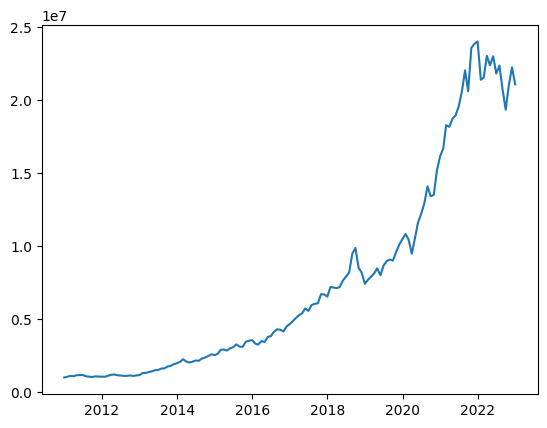

In [59]:
# portfolio value growth over time span
plt.plot(value_by_month_end)

In [118]:
# total portfolio percent return
total_pct_return = ((
    (value_by_month_end.loc[value_by_month_end.last_valid_index()] - 
    value_by_month_end.loc[value_by_month_end.first_valid_index()]) / 
    value_by_month_end.loc[value_by_month_end.first_valid_index()]
) * 100).values[0]

print(f'Total Portfolio Percent Return: {int(total_pct_return)}%')

Total Portfolio Percent Return: 2006%


In [62]:
# portfolio percent return by month
portfolio_pct_return_by_month = value_by_month_end.pct_change()[1:]
portfolio_pct_return_by_month.head()

,Portfolio Value
2011-01-31,0.049382
2011-02-28,0.057273
2011-03-31,-0.019396
2011-04-30,0.058845
2011-05-31,0.010830


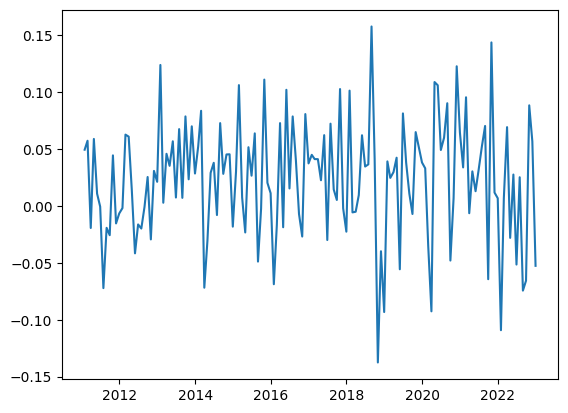

In [63]:
# plot of portfolio percent return
plt.plot(portfolio_pct_return_by_month)

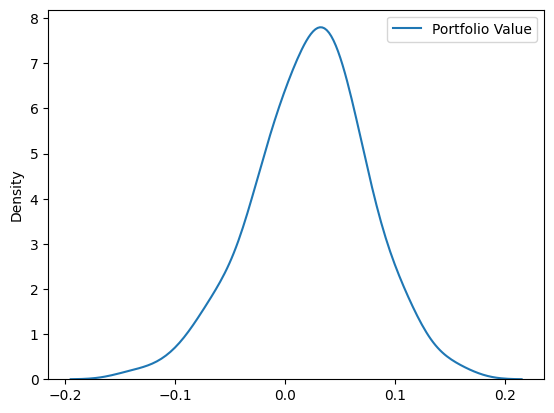

In [81]:
# density plot of percent returns
sns.kdeplot(portfolio_pct_return_by_month);

In [89]:
portfolio_pct_return_by_month.describe()

,Portfolio Value
count,144.000000
mean,0.022702
std,0.051705
min,-0.137573
25%,-0.007096
50%,0.027872
75%,0.056911
max,0.157676


In [72]:
# positive percent returns
positive_returns = portfolio_pct_return_by_month.loc[
    portfolio_pct_return_by_month[
        'Portfolio Value'
    ] > 0.0
]

# negative percent returns
negative_returns = portfolio_pct_return_by_month.loc[
    portfolio_pct_return_by_month[
        'Portfolio Value'
    ] < 0.0
]

In [73]:
# total positive and negative return months
print('Positive return months:', positive_returns.count().values[0])
print('Negative return months:', negative_returns.count().values[0])

Positive return months: 98
Negative return months: 46


## Cascading Momentum Strategy (Minus Survivorship Bias)